# Capstone Project - Best Place to Live in Paris, France

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

* Paris is an attractive city to work and live, but each district has its own specificities


* When ones wants to live there, it could be difficult to make an objective choice taking into consideration ones personal criterias


* Analyzing and comparing the characteristics of the 20 districts of Paris, such as venues available, crime rate or real estate prices can be a help for people who aim to live there


* This analysis aims to be a proof of concept. It takes into consideration a restricted range of criterias only in Paris. The final goal is to make it work with a wider range of cities and criterias

## Data <a name="data"></a>

The data needed are :

* Venues locations & characteristics using **Foursquare**
* Real estate prices using the website **https://ouinvestir.net/**
* Data about crime rate using **ONDRP data** (a French observatory of delinquency)

### Initialization and main data collection

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import csv
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes
import folium
import json
from pandas.io.json import json_normalize

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



In [139]:
# Main Dataframe creation
df = pd.DataFrame(columns = ['City', 'District', 'Postcode'])
# Adding Paris 20 districts
for i in range(1,21):
    if i<10:
        i_end="7500"+str(i)
    else:
        i_end="750"+str(i)
        
    df.loc[i]=["Paris", "Paris "+ str(i) ,int(i_end)]
df

,City,District,Postcode
1,Paris,Paris 1,75001
2,Paris,Paris 2,75002
3,Paris,Paris 3,75003
4,Paris,Paris 4,75004
5,Paris,Paris 5,75005
6,Paris,Paris 6,75006
7,Paris,Paris 7,75007
8,Paris,Paris 8,75008
9,Paris,Paris 9,75009
10,Paris,Paris 10,75010


### Criminality data

In [208]:
df_crime=pd.read_csv("Criminality.csv")
df_crime

,District,Violences physiques non crapuleuses /1000hab,Violences physiques crapuleuses /1000hab,Violences sexuelles /1000hab,Menaces /1000hab,Vols simples /1000hab,Cambriolages /1000hab,Destructions & degradations /1000hab
0,Paris 1,18.7,30.4,2.7,9.5,277.9,11.1,16.9
1,Paris 2,8.1,11.6,1.2,2.6,89.0,16.6,12.2
2,Paris 3,5.4,6.3,0.8,2.0,51.5,11.0,9.4
3,Paris 4,8.9,10.4,1.6,3.5,86.6,11.7,12.9
4,Paris 5,4.8,4.1,0.6,1.6,37.8,7.7,6.9
5,Paris 6,4.3,5.1,0.6,1.6,52.0,7.8,6.4
6,Paris 7,4.6,3.6,0.6,1.5,38.4,7.6,5.5
7,Paris 8,11.7,15.1,1.0,6.2,133.8,11.2,15.0
8,Paris 9,6.2,9.8,0.8,3.2,89.5,11.9,8.8
9,Paris 10,7.8,10.6,0.9,3.0,62.3,10.9,9.2


In [141]:
df_crime.shape

(20, 8)

### Scoring for criminality will be defined by the mean of the different crime types

In [142]:
df_crime['Criminality score']=round((df_crime.iloc[:,1]+df_crime.iloc[:,2]+df_crime.iloc[:,3]+df_crime.iloc[:,4]+df_crime.iloc[:,5]+df_crime.iloc[:,6]+df_crime.iloc[:,7])/7,1)
df_crime_mean=df_crime[['District','Criminality score']]
df_crime_mean

,District,Criminality score
0,Paris 1,52.5
1,Paris 2,20.2
2,Paris 3,12.3
3,Paris 4,19.4
4,Paris 5,9.1
5,Paris 6,11.1
6,Paris 7,8.8
7,Paris 8,27.7
8,Paris 9,18.6
9,Paris 10,15.0


### Real estate prices data

In [143]:
df_re=pd.read_csv("Real-estate.csv")
df_re

,District,Price (/m2)
0,Paris 1,12184
1,Paris 2,11039
2,Paris 3,11583
3,Paris 4,13701
4,Paris 5,12037
5,Paris 6,13429
6,Paris 7,17959
7,Paris 8,16537
8,Paris 9,10135
9,Paris 10,9072


### Lets concatenate the 3 previous dataframes

In [144]:
df_score=df.merge(df_crime_mean, how='left')
df_score=df_score.merge(df_re, how='left')
df_score

,City,District,Postcode,Criminality score,Price (/m2)
0,Paris,Paris 1,75001,52.5,12184
1,Paris,Paris 2,75002,20.2,11039
2,Paris,Paris 3,75003,12.3,11583
3,Paris,Paris 4,75004,19.4,13701
4,Paris,Paris 5,75005,9.1,12037
5,Paris,Paris 6,75006,11.1,13429
6,Paris,Paris 7,75007,8.8,17959
7,Paris,Paris 8,75008,27.7,16537
8,Paris,Paris 9,75009,18.6,10135
9,Paris,Paris 10,75010,15.0,9072


### Lets initialize geographical analysis

In [145]:
df_c=pd.read_csv('Coordinates.csv')
paris_data=df_score.merge(df_c, how='left')
paris_data

,City,District,Postcode,Criminality score,Price (/m2),latitude,longitude
0,Paris,Paris 1,75001,52.5,12184,48.8592,2.3417
1,Paris,Paris 2,75002,20.2,11039,48.8655,2.3426
2,Paris,Paris 3,75003,12.3,11583,48.8637,2.3615
3,Paris,Paris 4,75004,19.4,13701,48.8601,2.3507
4,Paris,Paris 5,75005,9.1,12037,48.8448,2.3471
5,Paris,Paris 6,75006,11.1,13429,48.8493,2.3300
6,Paris,Paris 7,75007,8.8,17959,48.8565,2.3210
7,Paris,Paris 8,75008,27.7,16537,48.8763,2.3183
8,Paris,Paris 9,75009,18.6,10135,48.8718,2.3399
9,Paris,Paris 10,75010,15.0,9072,48.8709,2.3561


In [146]:
geocoder = Nominatim(user_agent="my-application")
adresse = "Paris"
location = geocoder.geocode(adresse, True, 30)

latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Paris are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Paris are 48.8566969, 2.3514616.


In [147]:
# create map of Paris using latitude and longitude values
map_paris = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, city, district in zip(paris_data['latitude'], paris_data['longitude'], paris_data['City'], paris_data['District']):
    label = '{}, {}'.format(district, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)  
    
map_paris

### Foursquare Paris venues scraping

In [148]:
CLIENT_ID = '***'
CLIENT_SECRET = '***'
VERSION = '20200308'

In [151]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [152]:
paris_venues = getNearbyVenues(names=paris_data['District'],
                                   latitudes=paris_data['latitude'],
                                   longitudes=paris_data['longitude']
                                  )

Paris 1
Paris 2
Paris 3
Paris 4
Paris 5
Paris 6
Paris 7
Paris 8
Paris 9
Paris 10
Paris 11
Paris 12
Paris 13
Paris 14
Paris 15
Paris 16
Paris 17
Paris 18
Paris 19
Paris 20


In [153]:
print(paris_venues.shape)
paris_venues.head()

(1465, 7)


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Paris 1,48.8592,2.3417,Place du Louvre,48.859841,2.340822,Plaza
1,Paris 1,48.8592,2.3417,Église Saint-Germain-l'Auxerrois (Église Saint...,48.859520,2.341306,Church
2,Paris 1,48.8592,2.3417,Coffee Crêpes,48.858841,2.340802,Coffee Shop
3,Paris 1,48.8592,2.3417,Le Fumoir,48.860424,2.340868,Cocktail Bar
4,Paris 1,48.8592,2.3417,Cour Carrée du Louvre,48.860360,2.338543,Pedestrian Plaza


In [154]:
paris_venues.groupby('District').count()

,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
Paris 1,97,97,97,97,97,97
Paris 10,100,100,100,100,100,100
Paris 11,100,100,100,100,100,100
Paris 12,41,41,41,41,41,41
Paris 13,50,50,50,50,50,50
Paris 14,47,47,47,47,47,47
Paris 15,59,59,59,59,59,59
Paris 16,22,22,22,22,22,22
Paris 17,99,99,99,99,99,99


In [155]:
print('There are {} uniques categories.'.format(len(paris_venues['Venue Category'].unique())))

There are 207 uniques categories.


In [156]:
# one hot encoding
paris_onehot = pd.get_dummies(paris_venues[['Venue Category']], prefix="", prefix_sep="")

# add district column back to dataframe
paris_onehot['District'] = paris_venues['District'] 

# move district column to the first column
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]

paris_onehot.head()

,District,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,Paris 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Paris 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Paris 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Paris 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Paris 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [157]:
paris_onehot.shape

(1465, 208)

In [158]:
paris_grouped = paris_onehot.groupby('District').mean().reset_index()
paris_grouped

,District,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,Paris 1,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.010309,0.010309,...,0.010309,0.00000,0.000000,0.00000,0.00,0.010309,0.000000,0.030928,0.000000,0.00
1,Paris 10,0.000000,0.01,0.00,0.00,0.00,0.00,0.000000,0.010000,0.000000,...,0.000000,0.00000,0.000000,0.01000,0.00,0.010000,0.010000,0.010000,0.010000,0.00
2,Paris 11,0.000000,0.01,0.00,0.00,0.00,0.00,0.000000,0.010000,0.000000,...,0.000000,0.00000,0.000000,0.00000,0.00,0.020000,0.010000,0.030000,0.000000,0.01
3,Paris 12,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,...,0.000000,0.02439,0.000000,0.02439,0.00,0.000000,0.024390,0.024390,0.000000,0.00
4,Paris 13,0.000000,0.00,0.00,0.02,0.00,0.00,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.00000,0.00,0.000000,0.040000,0.000000,0.000000,0.00
5,Paris 14,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.021277,0.00000,0.00,0.021277,0.042553,0.021277,0.021277,0.00
6,Paris 15,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.00000,0.00,0.000000,0.016949,0.000000,0.000000,0.00
7,Paris 16,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.045455,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
8,Paris 17,0.010101,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.010101,...,0.000000,0.00000,0.000000,0.00000,0.00,0.000000,0.020202,0.070707,0.000000,0.00
9,Paris 18,0.000000,0.00,0.00,0.00,0.00,0.00,0.018868,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.00000,0.00,0.000000,0.018868,0.018868,0.000000,0.00


In [159]:
paris_grouped.shape

(20, 208)

In [160]:
num_top_venues = 5

for hood in paris_grouped['District']:
    print("----"+hood+"----")
    temp = paris_grouped[paris_grouped['District'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Paris 1----
               venue  freq
0  French Restaurant  0.12
1               Café  0.06
2             Bakery  0.05
3              Hotel  0.05
4     Clothing Store  0.04


----Paris 10----
               venue  freq
0  French Restaurant  0.08
1                Bar  0.07
2              Hotel  0.06
3        Pizza Place  0.04
4       Cocktail Bar  0.04


----Paris 11----
                venue  freq
0   French Restaurant  0.10
1                 Bar  0.06
2              Bistro  0.05
3  Italian Restaurant  0.04
4                Café  0.04


----Paris 12----
                venue  freq
0               Hotel  0.12
1              Bistro  0.07
2         Supermarket  0.07
3  Chinese Restaurant  0.05
4         Pizza Place  0.02


----Paris 13----
               venue  freq
0              Hotel  0.10
1  French Restaurant  0.08
2    Thai Restaurant  0.08
3  Indian Restaurant  0.06
4   Asian Restaurant  0.04


----Paris 14----
                venue  freq
0   French Restaurant  0.28
1  Italian 

In [213]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [214]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['District'] = paris_grouped['District']

for ind in np.arange(paris_grouped.shape[0]):
    district_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

district_venues_sorted.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Paris 1,French Restaurant,Café,Bakery,Hotel,Plaza,Pizza Place,Clothing Store,Historic Site,Wine Bar,Bar
1,Paris 10,French Restaurant,Bar,Hotel,Cocktail Bar,Pizza Place,Burger Joint,Bakery,Breakfast Spot,Restaurant,Theater
2,Paris 11,French Restaurant,Bar,Bistro,Italian Restaurant,Café,Coffee Shop,Wine Bar,Cocktail Bar,Pastry Shop,Supermarket
3,Paris 12,Hotel,Supermarket,Bistro,Chinese Restaurant,French Restaurant,Japanese Restaurant,Sporting Goods Shop,Bakery,Bar,Furniture / Home Store
4,Paris 13,Hotel,French Restaurant,Thai Restaurant,Indian Restaurant,Asian Restaurant,Bar,Vietnamese Restaurant,Bakery,Italian Restaurant,Chinese Restaurant


In [215]:
# set number of clusters
kclusters = 5

paris_grouped_clustering = paris_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 3, 3, 2, 2, 4, 2, 2], dtype=int32)

In [216]:
# add clustering labels
district_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

paris_merged = paris_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
paris_merged = paris_merged.join(district_venues_sorted.set_index('District'), on='District')

paris_merged.head() # check the last columns!

,City,District,Postcode,Criminality score,Price (/m2),latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Paris,Paris 1,75001,52.5,12184,48.8592,2.3417,1,French Restaurant,Café,Bakery,Hotel,Plaza,Pizza Place,Clothing Store,Historic Site,Wine Bar,Bar
1,Paris,Paris 2,75002,20.2,11039,48.8655,2.3426,1,French Restaurant,Italian Restaurant,Wine Bar,Cocktail Bar,Restaurant,Café,Bakery,Hotel,Pizza Place,Bistro
2,Paris,Paris 3,75003,12.3,11583,48.8637,2.3615,1,Bistro,Café,French Restaurant,Coffee Shop,Art Gallery,Bakery,Japanese Restaurant,Cocktail Bar,Burger Joint,Sandwich Place
3,Paris,Paris 4,75004,19.4,13701,48.8601,2.3507,1,French Restaurant,Hotel,Bakery,Art Gallery,Plaza,Clothing Store,Pub,Coffee Shop,Cocktail Bar,Tea Room
4,Paris,Paris 5,75005,9.1,12037,48.8448,2.3471,2,French Restaurant,Hotel,Bar,Italian Restaurant,Bakery,Pub,Creperie,Plaza,Wine Bar,Café


## Methodology <a name="methodology"></a>

* Now we have scrapped the venues of each district in Paris and clustered those districts, we are able to chose the cluster that matches the best with our own preferences.
* When the best cluster is chosen, we can compare each district inside it using crime rates and real estate prices to chose the best district to live.

## Analysis <a name="analysis"></a>

In [217]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged['latitude'], paris_merged['longitude'], paris_merged['District'], paris_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [218]:
#Cluster 0
paris_merged.loc[paris_merged['Cluster Labels'] == 0, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,District,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Paris 6,48.8493,2.330,0,French Restaurant,Bakery,Italian Restaurant,Hotel,Tea Room,Wine Bar,Plaza,Restaurant,Chocolate Shop,Art Gallery
6,Paris 7,48.8565,2.321,0,French Restaurant,Hotel,Café,Italian Restaurant,Bakery,Art Museum,Bistro,Coffee Shop,Japanese Restaurant,Plaza


In [219]:
#Cluster 1
paris_merged.loc[paris_merged['Cluster Labels'] == 1, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,District,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Paris 1,48.8592,2.3417,1,French Restaurant,Café,Bakery,Hotel,Plaza,Pizza Place,Clothing Store,Historic Site,Wine Bar,Bar
1,Paris 2,48.8655,2.3426,1,French Restaurant,Italian Restaurant,Wine Bar,Cocktail Bar,Restaurant,Café,Bakery,Hotel,Pizza Place,Bistro
2,Paris 3,48.8637,2.3615,1,Bistro,Café,French Restaurant,Coffee Shop,Art Gallery,Bakery,Japanese Restaurant,Cocktail Bar,Burger Joint,Sandwich Place
3,Paris 4,48.8601,2.3507,1,French Restaurant,Hotel,Bakery,Art Gallery,Plaza,Clothing Store,Pub,Coffee Shop,Cocktail Bar,Tea Room
9,Paris 10,48.8709,2.3561,1,French Restaurant,Bar,Hotel,Cocktail Bar,Pizza Place,Burger Joint,Bakery,Breakfast Spot,Restaurant,Theater
10,Paris 11,48.8574,2.3795,1,French Restaurant,Bar,Bistro,Italian Restaurant,Café,Coffee Shop,Wine Bar,Cocktail Bar,Pastry Shop,Supermarket
19,Paris 20,48.8646,2.3984,1,French Restaurant,Bar,Bakery,Japanese Restaurant,Italian Restaurant,Bistro,Café,Sushi Restaurant,Park,Plaza


In [220]:
#Cluster 2
paris_merged.loc[paris_merged['Cluster Labels'] == 2, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,District,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Paris 5,48.8448,2.3471,2,French Restaurant,Hotel,Bar,Italian Restaurant,Bakery,Pub,Creperie,Plaza,Wine Bar,Café
13,Paris 14,48.8331,2.3264,2,French Restaurant,Bar,Bakery,Italian Restaurant,Hotel,Bistro,Vietnamese Restaurant,Latin American Restaurant,Bookstore,Plaza
14,Paris 15,48.8412,2.3003,2,French Restaurant,Hotel,Coffee Shop,Supermarket,Italian Restaurant,Bar,Lebanese Restaurant,Korean Restaurant,Park,Thai Restaurant
16,Paris 17,48.8835,2.3219,2,French Restaurant,Wine Bar,Hotel,Bar,Restaurant,Italian Restaurant,Thai Restaurant,Coffee Shop,Asian Restaurant,Bookstore
17,Paris 18,48.8925,2.3444,2,French Restaurant,Bar,Pizza Place,Deli / Bodega,Italian Restaurant,Restaurant,Gastropub,Hotel,Café,Burger Joint
18,Paris 19,48.8817,2.3822,2,French Restaurant,Bar,Italian Restaurant,Restaurant,Pool,Historic Site,Diner,Café,Scenic Lookout,Moroccan Restaurant


In [221]:
#Cluster 3
paris_merged.loc[paris_merged['Cluster Labels'] == 3, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,District,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Paris 8,48.8763,2.3183,3,Hotel,Italian Restaurant,French Restaurant,Café,Bar,Bistro,Wine Shop,Bakery,Thai Restaurant,Korean Restaurant
8,Paris 9,48.8718,2.3399,3,Hotel,French Restaurant,Bistro,Pedestrian Plaza,Japanese Restaurant,Restaurant,Sandwich Place,Furniture / Home Store,Café,Coffee Shop
11,Paris 12,48.8412,2.3876,3,Hotel,Supermarket,Bistro,Chinese Restaurant,French Restaurant,Japanese Restaurant,Sporting Goods Shop,Bakery,Bar,Furniture / Home Store
12,Paris 13,48.8322,2.3561,3,Hotel,French Restaurant,Thai Restaurant,Indian Restaurant,Asian Restaurant,Bar,Vietnamese Restaurant,Bakery,Italian Restaurant,Chinese Restaurant


In [222]:
#Cluster 4
paris_merged.loc[paris_merged['Cluster Labels'] == 4, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,District,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Paris 16,48.8637,2.2769,4,Bakery,French Restaurant,Café,Restaurant,Hotel,Garden,Pizza Place,Train Station,Chinese Restaurant,Grocery Store


**Assuming cluster 2 is the most diversified and less touristical, lets compare the districts with the criterias we defined at the beginning**

In [224]:
chosen_cluster=paris_merged.loc[paris_merged['Cluster Labels'] == 2, paris_merged.columns[[1,7,3,4]]]
chosen_cluster

,District,Cluster Labels,Criminality score,Price (/m2)
4,Paris 5,2,9.1,12037
13,Paris 14,2,5.7,9389
14,Paris 15,2,5.0,9435
16,Paris 17,2,6.4,10778
17,Paris 18,2,11.1,15772
18,Paris 19,2,7.9,10114


In [225]:
a=list(chosen_cluster['Criminality score']*1000)
b=list(chosen_cluster['Price (/m2)'])
c=list(chosen_cluster['District'])

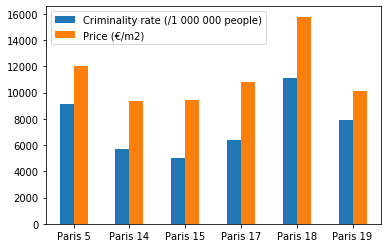

In [226]:
df_plot = pd.DataFrame({'Criminality rate (/1 000 000 people)': a, 'Price (€/m2)': b}, index=c)
ax = df_plot.plot.bar(rot=0)

## Results and Discussion <a name="results"></a>

* This analysis shows that disricts 14 and 15 are both interesting viewing real estate prices and criminality rate.
* Assuming that we want a "day-to-day" way of life, district 15 seems the best choice because of the number of supermarkets (4th most common venue)

## Conclusion <a name="conclusion"></a>

* This analysis helped us to chose a convenient place to live in Paris, by comparing each of the 20 disctricts in terms of most common venues, criminality rates and real estate prices
* Since the 15th district of Paris is large, the next step could be an analysis of the neighborhoods of this district
* We can also take into consideration density of population or transportation facilities to make a more precise choice